# From Images and Masks to Loading Data

In this we'll go take a set of Images and Target labels (black and white mask images), transform them into Pytorch Tensors, and set them up in a Dataloader to be fed into a Neural Net model

We'll be using PIL / Pillow to load images, as torchvision has built in support for that in its transforms.

Since Masks are images we won't need to load them with numpy

# 0. Python Setup

Imports

In [1]:
#Jupyter Notebook Specific
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
print(f"matplotlib loaded: {matplotlib.__version__}")

matplotlib loaded: 3.2.1


In [2]:
import os
import glob
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import PIL
from PIL import Image
print(f"torch {torch.__version__}, torchvision {torchvision.__version__}, PIL {PIL.__version__}, loaded")

torch 1.4.0, torchvision 0.5.0, PIL 7.1.1, loaded


# 1. Image and Target Loading

We also want to make sure we're loading our images and targets as we intend, so let's double check that first

Our example will be to segment what is UI and what is not UI, so we can get away with just one color to signal UI. 

We're treating the target as binary, so 'L' or '1' Mode in PIL should work. We most care about it being binary 0 and 1 after transforming to torch tensor

**SIDE-NOTE** In a multi-class segmentation problem (e.x. self-driving cars segmenting 'road', 'sky', 'people', 'cars', etc.) we often use different colors to represent different classes in our target data, which requires an additional step to our data-loading pipeline. The colors used don't matter, so long as they are unique and consistent; since the color values are known, we make a pytorch tensor of all 0's for each class (which is the same width and height as our target segmentation image), then fill each with a 1 only where the target segmentation pixels are equal to that specific class color value.

One caveat to this is that you cannot have overlapping segmentations. You'd need to either save a segmentation image for each class, save the segmentations as multi-dimensional (as many dimensions as you have classes) tensors / arrays, or perform some kind of bit shifting or mod operations on pixel values to allow multiple class-colors to overlap and add together.


(Image, Target) loaded with pil: (<class 'PIL.Image.Image'>, <class 'PIL.Image.Image'>), size: ((256, 224), (256, 224)), mode: ('RGB', '1')
Image extrema R, G, B: ((0, 255), (0, 251), (0, 255)), Target extrema and palette B&W: (0, 255), [43956, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

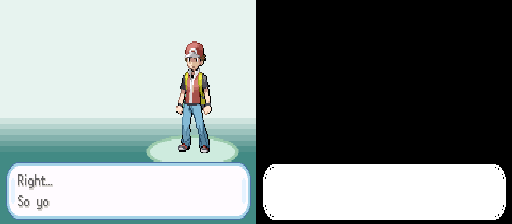

In [3]:
test_image_path = os.path.join('.', 'test_inputs', '1_input.png')
test_target_path = os.path.join('.', 'test_inputs', '1_target.jpg')

image = Image.open(test_image_path).convert('RGB')
target = Image.open(test_target_path).convert('1')

width, height = image.size
# Hacky image grid with PIL, torchvision has a decent built in function for use with tensors, and of course matplotlib has subplots()
test_image = Image.new('RGB', (width*2, height))
test_image.paste(image, (0,0))
test_image.paste(target, (width,1))

print(f"(Image, Target) loaded with pil: {type(image), type(target)}, size: {(image.size), (target.size)}, mode: {(image.mode), (target.mode)}")
# Check our scales and colors at load. We'll need to check this again after converting to tensors
print(f"Image extrema R, G, B: {image.getextrema()}, Target extrema and palette B&W: {target.getextrema()}, {target.histogram()}")
test_image

# 2. Pytorch Dataset

Pytorch has 2 tools that make feeding data into your deep learning model easier and rather generalizable to different tasks, data, and domains. These are the `Dataset` and `Dataloader` in the `torch.utils.data` module

The Dataset Class handles the length of our data and how we receive each sample item. Note that the type of a sample `dataset[x_index]` depends on the `__getitem__` function, but also on the `transform` that is passed in. Also note this sample in the dataset will be a single sample and not have a Batch dimension, even if it is a tensor (this matters at the DataLoader step).

We'll start with the dataset and provide plenty of comments.

**NOTE** If you're just loading Images (and not targets, e.x. in an auto-encoding task), or are loading Images by class (e.x. predicting animal or pokemon type or something), then [torchvision imagefolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) is probably the easiest thing to use, it returns a tuple. (sidenote it expects a root directory filled with at least 1 directory of images, that's how it seperates by class)

[Dataloading Tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [4]:
# Optional, i prefer this syntax for accessing the data with data.image and data.target or data[0], data[1]
Sample = namedtuple('Sample', ['image', 'target'])

class UIImageMaskDataset(torch.utils.data.Dataset):
    """
    Expects images to be .pngs in data_dir folder of form `1_input.png`, target ui masks to be .jpg files with same number as image and target `1_target.jpg`
    Initialize
    Param: data_dir (String) path to directory with images and targets
    Transform: Torchvision transform to be applied on each image & target pair when fetched from the dataset
    """
    def __init__(self, data_dir='./test_inputs', transform=None):
        self.data_dir = data_dir
        
        # Get file paths
        # We could use a more clear wildcard (like *_input.png and *_target.jpg if we set up our filenames like that).
        self.image_list = glob.glob(f'{self.data_dir}/*.png')
        self.target_list = glob.glob(f'{self.data_dir}/*.jpg')
        
        # For use in methods
        self.length = len(self.image_list)
        self.transform = transform
        
        # Basic Error checking, just for testing
        if self.transform is None:
            print('No transform on data, you probably need at least ToTensor()')
        if len(self.image_list) != len(self.target_list):
            print('Image list and Target list not same length')

    def __len__(self):
        """
        Required by Pytorch. Return the amount of samples. 
        (For overfitting you can make this function return a fixed number and __getitem__ return one image always. 
            It can even made infinite with generators, but that's an advanced topic)
        """
        return self.length

    def __getitem__(self, idx):
        """
        Also required by Pytorch. 
        Loads input and target
        Do transformation if necessary
        Return a `sample` / `item`, meaning an input and target pair.
        For efficiency usually you do the actual loading here and not in the __init__.
            The Dataloader uses multiple processes to call __getitem__
            (With larger amounts of RAM you can preload images)
        Return type and format will vary from person to person, I prefer using a NamedTuple. 
            I find this to be the most compatible with the Dataloader default Collation,
            also it's readable: you can access with `data.image` and `data.target` instead of `data[0]` and `data[1]` (which you can also still do)
        Other Return types are typically plain tuple (usually input first, target second), and dictionary
            dictionary and namedtuple allow you to expand your targets for doing more complex tasks (e.x. bounding boxes and segmentations and class labels)
            without having tuples with many numbered elements
        """
        screenshot_file = self.image_list[idx]
        target_file = self.target_list[idx]

        image = Image.open(screenshot_file).convert('RGB')
        target = Image.open(target_file).convert('1')

        if self.transform:
            image, target = self.transform(image, target)

        # sample = {'image': image, 'target': target}
        return Sample(image, target)
    
test_dataset = UIImageMaskDataset()
print(f"Created test Data: {type(test_dataset)}.") 
print(f"Len: {len(test_dataset)}")
print(f"Type of first item: {type(test_dataset[0])}. ")
print(f"Type of first item.image: {type(test_dataset[0].image)}")
print(f"Type of first item.target: {type(test_dataset[0].target)}")

No transform on data, you probably need at least ToTensor()
Created test Data: <class '__main__.UIImageMaskDataset'>.
Len: 1
Type of first item: <class '__main__.Sample'>. 
Type of first item.image: <class 'PIL.Image.Image'>
Type of first item.target: <class 'PIL.Image.Image'>


# 2. Load the folder into a Dataset

Depending on your task you may not need to transform it at all (ex. a class name like 'cheese')

In our case we need to make sure whatever we do to the Image we also do to the Target mask. Most importantly, we need to convert both from PIL images to Pytorch Tensors so that they can be ingested in the model / network.

We'll also perform a resize, because reducing image size reduces the amount of data passing through the network and also to demonstrate Composing a chain of transforms

We use transform `ToTensor()` from [torchvision transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) because it's the simplest conversion from PIL to Tensor. You usually want to do this last, depending on the other transforms of course

**Always remember your target image!**

But this function only takes one input... So we can either use the 'Functional' version or write our own class. We'll take the class route, which lets you chain more easily.

If using random transforms on images and image targets make sure the same randomness is applied to both (you'll probably need to write your own transforms)

In a more advanced case we can chain together more transforms like crops, flips, and rotations to vary the training data. Typically we don't test / validate on data with as many transforms though. 

One rather important transform we're ignoring for now is image normalization, which brings all of your dataset images within the same range using the entire dataset mean and standard deviation.

Torchvision `ToTensor()` normalizes to a 0-1 scale which will keep our model's gradients in check. To go further we'd get the mean and std of our overfit image or dataset

**NOTE** many people import torchvision.transforms as T or similar. Feel free to do the same. I usually write my own transforms (ex. `input_target_transforms.py` for auto encoders, and import as `TT` or `Transforms` for clarity)

In [5]:
class ImageTargetToTensor(object):
    def __call__(self, image, target):
        # Transform Classes built with __call__ act kind of like a function once you assign an instance to a variable
        tv_tt = torchvision.transforms.ToTensor()
        # transform image to tensor with torchvision transform
        image = tv_tt(image)
        # same with target
        target = tv_tt(target)
        return (image, target)


class ImageTargetResize(object):
    def __init__(self, size):
        """
        size: int will reduce shorter side to size param
             tuple of (int, int) will resize to (height, width) from size param
        returns tuple of (resized_image, resized_target)
        """
        self.size = size

    def __call__(self, image, target):
        resize_transform = torchvision.transforms.Resize(self.size)
        image = resize_transform(image)
        target = resize_transform(target)
        return (image, target)
    
class ImageTargetCompose(object):
    def __init__(self, transforms):
        """
        transforms: list of transforms that take in image and target and return tuples of (transformed_image, transformed_target)
        returns tuple of (image, target) after going through each transform in list
        """
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target
    
training_transform = ImageTargetCompose([
    ImageTargetResize((256,256)),
    ImageTargetToTensor()
])

UI_DATASET = UIImageMaskDataset(data_dir="./test_inputs", transform=training_transform)
sample = UI_DATASET[0]

print(f"Created Ui dataset: {type(UI_DATASET)}.") 
print(f"Len: {len(UI_DATASET)}")
print(f"Type of first item: {type(sample)}. len {len(sample)} ")
print(f"item.image  Type: {type(sample.image)}. Datatype: {sample.image.dtype}.")
print(f"            Shape: {sample.image.shape}, Extrema: ({sample.image.min()}, {sample.image.max()}), Unique: ({len(sample.image.unique())} unique colors)")
print(f"item.target Type: {type(sample.target)}. Datatype: {sample.target.dtype}.")
print(f"            Shape: {sample.target.shape}, Extrema: ({sample.target.min()}, {sample.target.max()}), Unique: ({sample.target.unique()})")

Created Ui dataset: <class '__main__.UIImageMaskDataset'>.
Len: 1
Type of first item: <class '__main__.Sample'>. len 2 
item.image  Type: <class 'torch.Tensor'>. Datatype: torch.float32.
            Shape: torch.Size([3, 256, 256]), Extrema: (0.0, 1.0), Unique: (247 unique colors)
item.target Type: <class 'torch.Tensor'>. Datatype: torch.float32.
            Shape: torch.Size([1, 256, 256]), Extrema: (0.0, 1.0), Unique: (tensor([0., 1.]))


torch.Size([3, 256, 256])


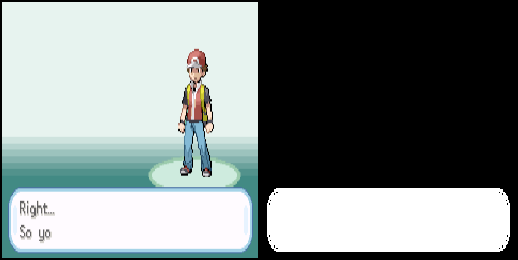

In [6]:
# As a double check, we should make sure our transforms do what we intend, especially if rotating / cropping image and target
# We need to jump through one hoop by making the target seem like an RGB image to let torchvision see it
#  We also need to jump through another hoop to display a torch tensor as an image, using torchvision transforms ToPILImage works, numpy and matplotlib also work

viz_image = sample.image
viz_target = sample.target
viz_target = viz_target.repeat((3,1,1))
print(viz_target.shape)
grid = torchvision.utils.make_grid([viz_image, viz_target])
pil_grid = torchvision.transforms.ToPILImage()(grid)
pil_grid

# 3. Load into DataLoader

This will be the last part we cover, as after this is running training samples through a model!

The Pytorch Dataloader works pretty efficiently and takes a lot of effort out of batching your samples when looping through your dataset.

In most cases you can use `shuffle=True` on training and `shuffle=False` on validation / test and not worry about a sampler / batch sampler.

`drop_last=True` will make it so you end on the last full batch of data (ex if you have 999 samples and batch size of 4 then the last batch could only have 3 samples, this flag ignores that un-full batch of 3)

`batch_size` tends to depend on the size of your GPU(s), `num_workers` on the other hand scales with CPU processor cores that you have (probably 4, 2, maybe 1, maybe 8, if you have 16 you probably know; depends on your machine).

The dataloader gives results batched along a new dimension, meaning each tensor representing a whole batch of images has dimensions like this: `[ Batch_Size, Channels, Height, Width ]`. It does this using the `collate function`, which I generally leave default and is why I return tuples in Dataset implementations

**NOTE** You generally only want to touch your dataloaders (i.e. get a batch from them) when you are looping through training, as they are implemented as generators, which will continue sampling forward by default whenever you get a `next()` item from it. In other words you can't get a specific index from them (you always can from the underlying dataset though), and if you access the first sample then the training may be a bit messed up because it will start from the second sample .

[Dataloader Documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [7]:
TRAIN_DATALOADER = torch.utils.data.DataLoader(UI_DATASET, batch_size=1, shuffle=True, num_workers=1, drop_last=True)
print(f"Length of Train loader: {len(TRAIN_DATALOADER)} batches")

for batch_num, sample in enumerate(TRAIN_DATALOADER):
    print(f"batch number: {batch_num + 1}")
    batch_images = sample.image
    batch_targets = sample.target
    # one liner: batch_images, batch_targets = sample
    print(f"batch images  Type: {type(batch_images)}. Datatype: {batch_images.dtype}.")
    print(f"            Shape: {batch_images.shape}, Extrema: ({batch_images.min()}, {batch_images.max()}), Unique: ({len(batch_images.unique())} unique colors)")
    print(f"batch targets Type: {type(batch_targets)}. Datatype: {batch_targets.dtype}.")
    print(f"            Shape: {batch_targets.shape}, Extrema: ({batch_targets.min()}, {batch_targets.max()}), Unique: ({batch_targets.unique()})")
    

Length of Train loader: 1 batches
batch number: 1
batch images  Type: <class 'torch.Tensor'>. Datatype: torch.float32.
            Shape: torch.Size([1, 3, 256, 256]), Extrema: (0.0, 1.0), Unique: (247 unique colors)
batch targets Type: <class 'torch.Tensor'>. Datatype: torch.float32.
            Shape: torch.Size([1, 1, 256, 256]), Extrema: (0.0, 1.0), Unique: (tensor([0., 1.]))


# 4. BONUS: Overfit Dataset

We've seen how to load and transform images, and this will almost definitely work with a larger folder of images, and a larger batch size, but lets make sure.

In [8]:
class OverfitDataset(torch.utils.data.Dataset):

    def __init__(self, input_file='./test_inputs/1_input.png', target_file='./test_inputs/1_target.jpg', number_of_samples=2000, transform=None):
        self.image = Image.open(input_file).convert('RGB')
        self.target = Image.open(target_file).convert('1')
        
        # For use in methods
        self.length = number_of_samples
        self.transform = transform
        
        # Basic Error checking, just for testing
        if self.transform is None:
            print('No transform on data, you probably need at least ToTensor()')

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        """
        We apply transform in getitem in case you want to do some random transforms in the overfit training. 
            You could just do the transform originally in init for the overfit case
            Shouldn't be a hit to performance when just using ToTensor anyway
        """
        image, target = (self.image, self.target)
        if self.transform:
            image, target = self.transform(image, target)

        # sample = {'image': image, 'target': target}
        return Sample(image, target)
    
overfit_dataset = OverfitDataset(input_file='./test_inputs/1_input.png', target_file='./test_inputs/1_target.jpg', number_of_samples=100, transform=training_transform)
sample = overfit_dataset[0]

print(f"Created overfit dataset: {type(overfit_dataset)}.") 
print(f"Len: {len(overfit_dataset)}")
print(f"Type of first item: {type(sample)}. len {len(sample)} ")
print(f"item.image  Type: {type(sample.image)}. Datatype: {sample.image.dtype}.")
print(f"            Shape: {sample.image.shape}, Extrema: ({sample.image.min()}, {sample.image.max()}), Unique: ({len(sample.image.unique())} unique colors)")
print(f"item.target Type: {type(sample.target)}. Datatype: {sample.target.dtype}.")
print(f"            Shape: {sample.target.shape}, Extrema: ({sample.target.min()}, {sample.target.max()}), Unique: ({sample.target.unique()})")

OVERFIT_LOADER = torch.utils.data.DataLoader(overfit_dataset, batch_size=16, shuffle=True, num_workers=1, drop_last=True)
print(f"Length of overfit loader: {len(OVERFIT_LOADER)} batches")
for batch_num, sample in enumerate(OVERFIT_LOADER):
    print("----------------------------------")
    print(f"batch number: {batch_num + 1}")
    batch_images = sample.image
    batch_targets = sample.target
    # one liner: batch_images, batch_targets = sample
    
    print(f"batch images  Type: {type(batch_images)}.")
    print(f"            Shape: {batch_images.shape}")
    print(f"batch targets Type: {type(batch_targets)}.")
    print(f"            Shape: {batch_targets.shape}")

Created overfit dataset: <class '__main__.OverfitDataset'>.
Len: 100
Type of first item: <class '__main__.Sample'>. len 2 
item.image  Type: <class 'torch.Tensor'>. Datatype: torch.float32.
            Shape: torch.Size([3, 256, 256]), Extrema: (0.0, 1.0), Unique: (247 unique colors)
item.target Type: <class 'torch.Tensor'>. Datatype: torch.float32.
            Shape: torch.Size([1, 256, 256]), Extrema: (0.0, 1.0), Unique: (tensor([0., 1.]))
Length of overfit loader: 6 batches
----------------------------------
batch number: 1
batch images  Type: <class 'torch.Tensor'>.
            Shape: torch.Size([16, 3, 256, 256])
batch targets Type: <class 'torch.Tensor'>.
            Shape: torch.Size([16, 1, 256, 256])
----------------------------------
batch number: 2
batch images  Type: <class 'torch.Tensor'>.
            Shape: torch.Size([16, 3, 256, 256])
batch targets Type: <class 'torch.Tensor'>.
            Shape: torch.Size([16, 1, 256, 256])
----------------------------------
batch num